In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2"

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 3060 || GPU || 9.4 GiB
 /device:GPU:1 ||  NVIDIA GeForce RTX 3060 || GPU || 9.4 GiB


In [3]:
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from collections import Counter
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import numpy as np
import pandas as pd
from IPython.display import Image, HTML
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, " Type:", gpu.device_type)

Name: /physical_device:GPU:0  Type: GPU
Name: /physical_device:GPU:1  Type: GPU


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [6]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
# # Define strategy
# strategy = tf.distribute.MirroredStrategy((gpus),
#                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [8]:
# strategy = tf.distribute.MirroredStrategy(gpus,
#                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [9]:
# Define strategy
# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')


In [10]:
# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#     for device in physical_devices:
#         tf.config.experimental.set_memory_growth(device, True)
#     print("GPU memory growth has been limited successfully!")
# except:
#     print("Failed to limit the GPU memory growth.")

In [11]:
IMG_HEIGHT=48 
IMG_WIDTH = 48
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

IMAGE_SHAPE = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

batch_size=32*strategy.num_replicas_in_sync
# batch_size=32 * strategy.num_replicas_in_sync
# global_batch_size = batch_size * strategy.num_replicas_in_sync

PATIENCE =10

epochs = 100

csv_logger = CSVLogger('log.csv', separator=',', append=True)

ADAM_LEARNING_RATE = 0.0001

class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

train_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/AffectNet Resize/train 7/'
validation_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/AffectNet Resize/test 7/'

In [12]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='rgb',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='rgb',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

Found 22221 images belonging to 7 classes.
Found 5545 images belonging to 7 classes.


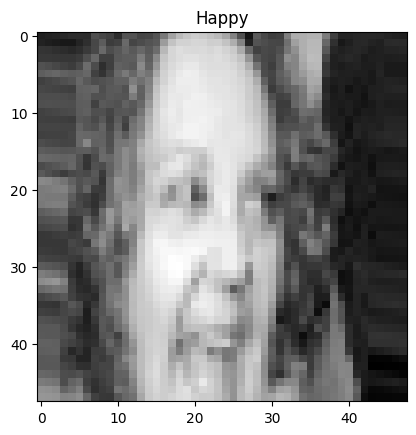

In [14]:
#Verify our generator by plotting a few faces and printing corresponding labels

img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()
##########################################################

In [15]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# Get the counts of each expression in the train and test sets
train_count = count_exp(train_data_dir, "train")
test_count = count_exp(validation_data_dir, "test")

# Concatenate the train and test counts
df_counts = pd.concat([train_count, test_count])

# Display the concatenated counts as an HTML table
display(HTML(df_counts.to_html()))

,anger,disgust,fear,happy,neutral,sad,surprise
train,2910,2093,2897,4036,4105,2744,3436
test,721,520,724,1009,1026,686,859


In [16]:
# Data labels

class_labels = validation_generator.class_indices
class_labels

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [17]:
# See the shape of any data

train_sample=next(train_generator)
print(train_sample[0].shape)

(64, 48, 48, 3)


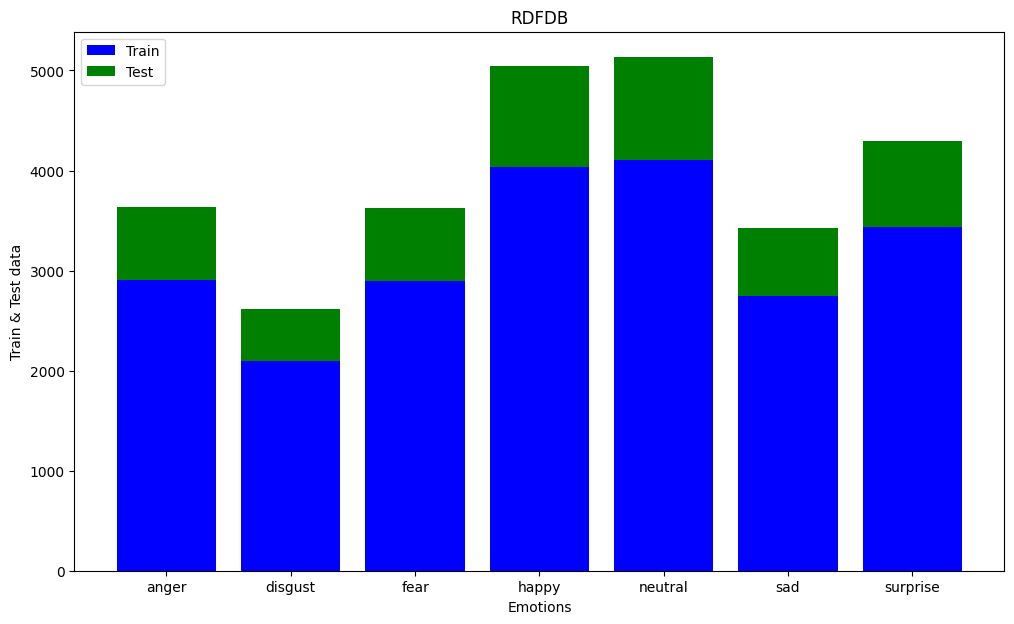

In [18]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='green')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("RDFDB")
plt.savefig('distribution.png')
plt.show()

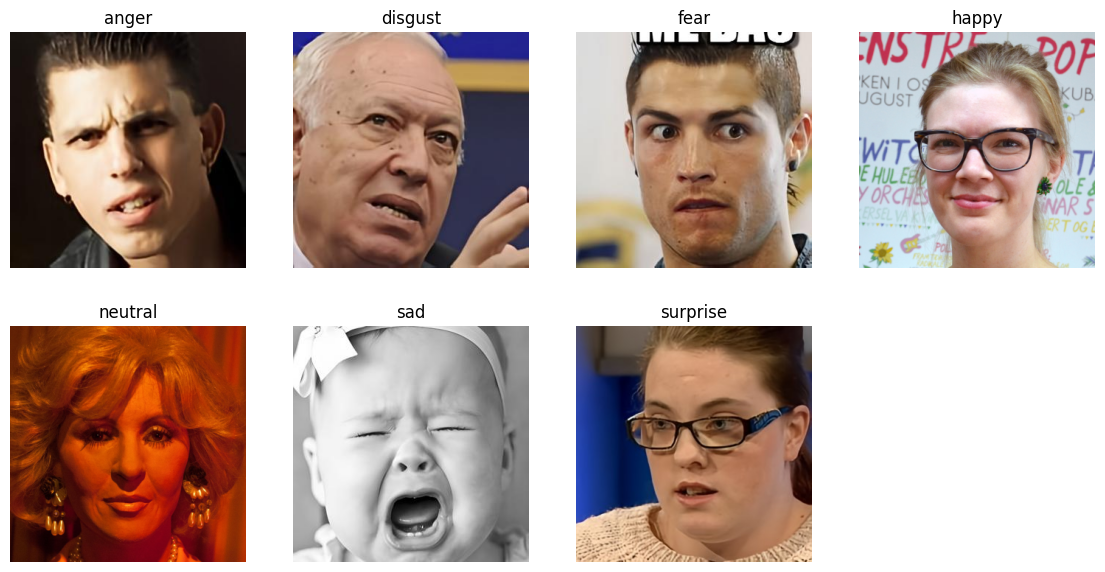

In [19]:
# Define a function to get a random image path from each class directory
def get_random_image_path(path):
    # Get a sorted list of image file names
    files = sorted(os.listdir(path))
    # Choose a random image file
    file = random.choice(files)
    # Return the full path to the image file
    return os.path.join(path, file)

# Create a 2x4 grid of plots
plt.figure(figsize=(14, 7))
i = 1

# Loop over each class directory in the train data directory
for expression in os.listdir(train_data_dir):
    # Get the path to a random image file in the directory
    img_path = get_random_image_path(os.path.join(train_data_dir, expression))
    # Load the image
    img = load_img(img_path)
    # Plot the image and set the title to the class name
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis("off")
    i += 1

# Show the plot
plt.show()

In [20]:
with strategy.scope():
      
    # Define input shape
    input_shape = (48, 48, 3)

    # Define input tensor
    input_tensor = tf.keras.Input(shape=input_shape)

    # Define shared convolutional layers
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_tensor)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)

    # Define branch for face detection
    face_detection_branch = MaxPooling2D(pool_size=(2, 2))(conv3)
    face_detection_branch = Conv2D(128, (3, 3), padding='same', activation='relu')(face_detection_branch)
    face_detection_branch = Flatten()(face_detection_branch)
    face_detection_branch = Dense(64, activation='relu')(face_detection_branch)

    # Define branch for emotion recognition with attention mechanism
    emotion_recognition_branch = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    emotion_recognition_branch = MaxPooling2D(pool_size=(2, 2))(emotion_recognition_branch)
    emotion_recognition_branch = Conv2D(256, (3, 3), padding='same', activation='relu')(emotion_recognition_branch)
    emotion_recognition_branch = MaxPooling2D(pool_size=(2, 2))(emotion_recognition_branch)
    attention_size = 32
    num_heads = 4
    attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=attention_size)(emotion_recognition_branch, emotion_recognition_branch)
    attention_layer = tf.keras.layers.LayerNormalization()(attention_layer)
    emotion_recognition_branch = Dense(128, activation='relu')(attention_layer)
    emotion_recognition_branch = Dropout(0.5)(emotion_recognition_branch)
    # Flatten the output of the emotion recognition branch
    emotion_recognition_branch = Flatten()(emotion_recognition_branch)

    # Merge the two branches
    merged = tf.keras.layers.concatenate([face_detection_branch, emotion_recognition_branch])

    # Define output layer
    output = Dense(7, activation='softmax')(merged)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output)

    # # Compile model
    # def f1_score(y_true, y_pred): #taken from old keras source code
    #     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    #     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    #     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    #     precision = true_positives / (predicted_positives + K.epsilon())
    #     recall = true_positives / (possible_positives + K.epsilon())
    #     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    #     return f1_val

    # METRICS = [
    #     tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    #     tf.keras.metrics.Precision(name='precision'),
    #     tf.keras.metrics.Recall(name='recall'),  
    #     tf.keras.metrics.AUC(name='auc'),
    #     f1_score,
    # ]

    # adam = Adam(learning_rate= ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    # model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)


    # counter = Counter(train_generator.classes)                          
    # max_val = float(max(counter.values()))       
    # class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

    # lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE, verbose = 1,factor = 0.50, min_lr = 1e-10)
    # mcp = ModelCheckpoint('model.h5')
    # es = EarlyStopping(verbose=1, patience=20)

    # model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

    ###########################################################
    train_path = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/AffectNet Resize/train 7/'
    test_path = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/AffectNet Resize/test 7/'

    num_train_imgs = 0
    for root, dirs, files in os.walk(train_path):
        num_train_imgs += len(files)
        
    num_test_imgs = 0
    for root, dirs, files in os.walk(test_path):
        num_test_imgs += len(files)

    print(num_train_imgs)
    print(num_test_imgs)

    
    ###########################################################

    

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
22221
5545


In [21]:
history = model.fit(train_generator,
                    steps_per_epoch=num_train_imgs//batch_size,
                    validation_data = validation_generator,
                    validation_steps=num_test_imgs//batch_size,
                    epochs = epochs,
                    # callbacks=[lrd,mcp,es,csv_logger],
                    # class_weight = class_weights
                    )

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to (

KeyboardInterrupt: 

In [ ]:
save_model = model.save('SMMB_AffectNet.h5')

In [23]:
model = load_model('MultiBranch_48_48e_RAF2.h5')

2/2 [==============================] - 5s 8ms/step
Accuracy =  0.765625


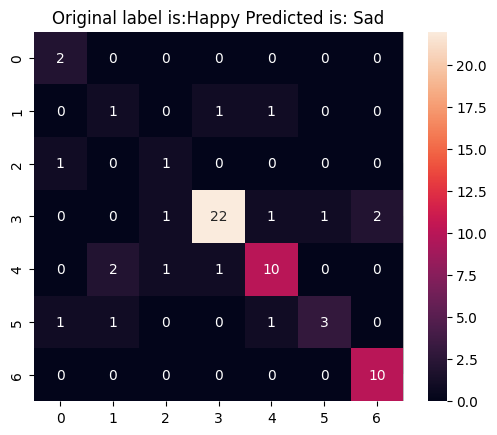

In [ ]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 13ms/step
Accuracy =  0.859375


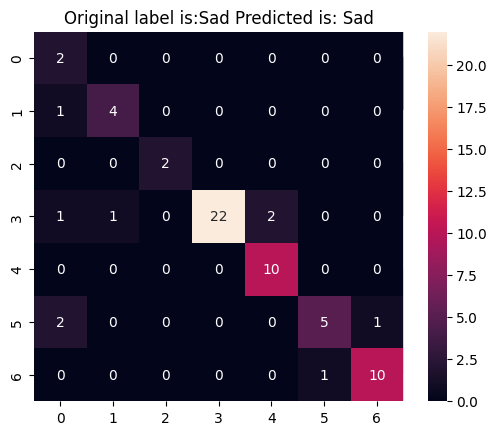

2/2 [==============================] - 0s 14ms/step
Accuracy =  0.5


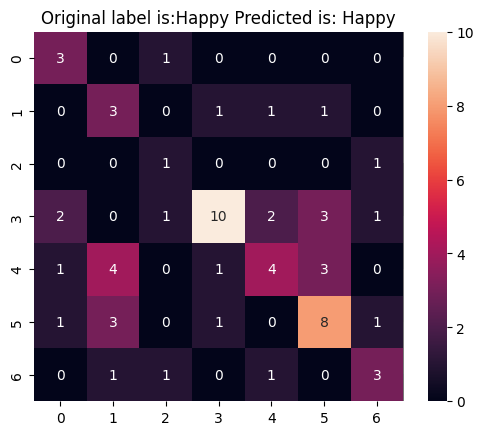

In [ ]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


1/2 [==============>...............] - ETA: 0s

In [ ]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 65.86707746478874
Angry 258/4606 acc: 64.0
Disgust 261/4606 acc: 58.6
Fear 106/4606 acc: 58.5
Happy 1765/4606 acc: 71.8
Neutral 948/4606 acc: 56.1
Sad 727/4606 acc: 61.1
Surprise 479/4606 acc: 77.0


              precision    recall  f1-score   support

       Angry       0.50      0.64      0.56       258
     Disgust       0.29      0.59      0.39       261
        Fear       0.23      0.58      0.33       106
       Happy       0.94      0.72      0.81      1765
     Neutral       0.69      0.56      0.62       948
         Sad       0.60      0.61      0.60       727
    Surprise       0.67      0.77      0.72       479

    accuracy                           0.66      4544
   macro avg       0.56      0.64      0.58      4544
weighted avg       0.73      0.66      0.68      4544



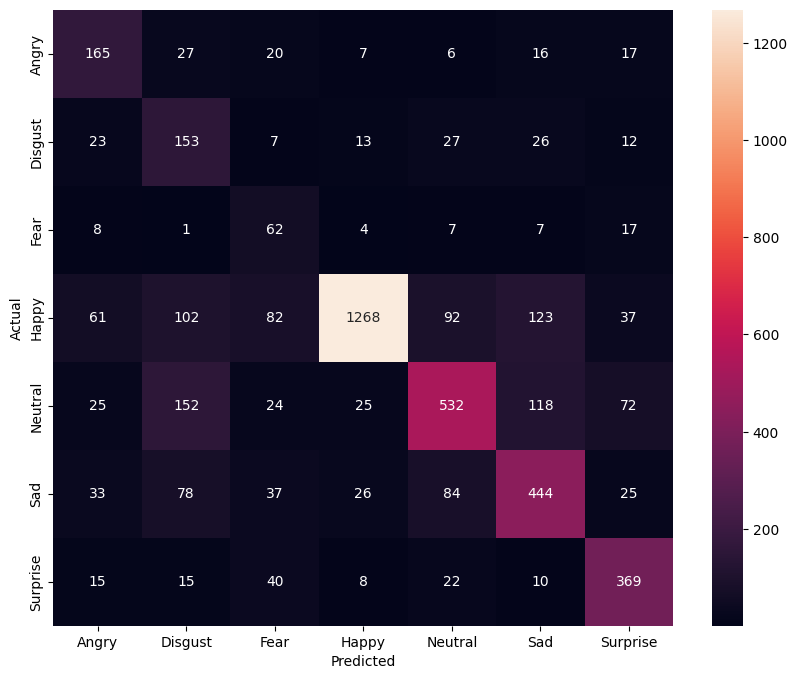

In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen Batch

In [ ]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [ ]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


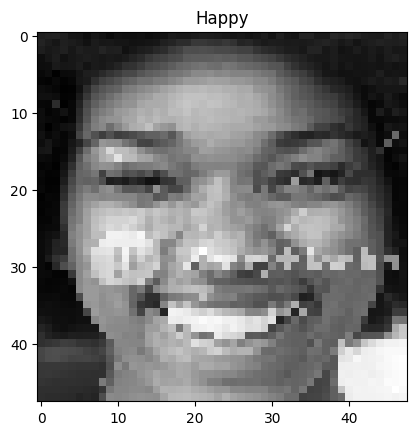

In [ ]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Worst batch saved
2/2 [==============================] - 0s 13ms/step
Accuracy =  0.5


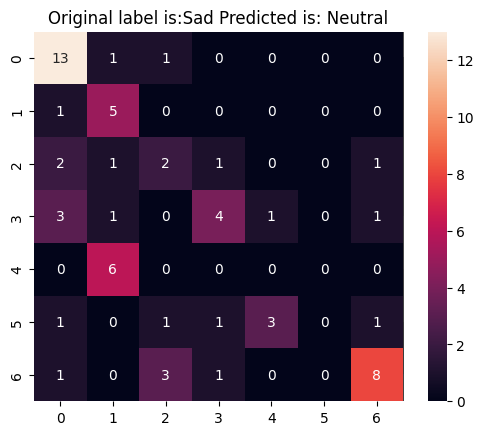

2/2 [==============================] - 0s 15ms/step
Accuracy =  0.25


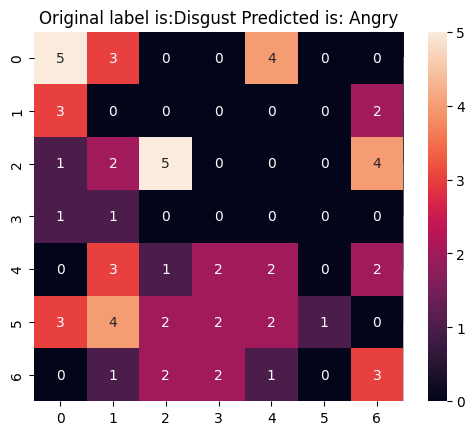

In [ ]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


NameError: name 'test_generator' is not defined

In [ ]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

NameError: name 'accuracy_score' is not defined

              precision    recall  f1-score   support

       Angry       0.45      0.79      0.57       295
     Disgust       0.70      0.08      0.14       294
        Fear       0.73      0.23      0.35       293
       Happy       0.60      0.86      0.70       291
     Neutral       0.37      0.83      0.51       294
         Sad       0.48      0.26      0.34       291
    Surprise       0.71      0.41      0.52       290

    accuracy                           0.49      2048
   macro avg       0.58      0.49      0.45      2048
weighted avg       0.58      0.49      0.45      2048



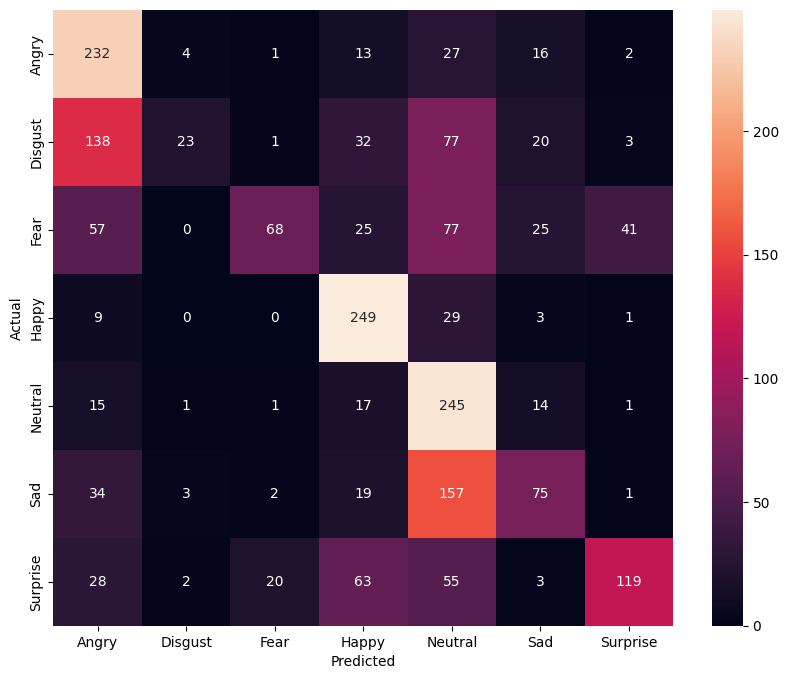

In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with Images

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
